# **Preliminares**

In [34]:
!pip install bayesian-optimization

In [35]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from bayes_opt import BayesianOptimization

import time
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import KFold
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [36]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [37]:
# Startup Google CoLab
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False


Note: using Google CoLab


In [38]:
epochs = 30

SPLITS = 2
EPOCHS = 100
PATIENCE = 10

In [39]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

#**Load dataset**

In [40]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [41]:
labels_map = {0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

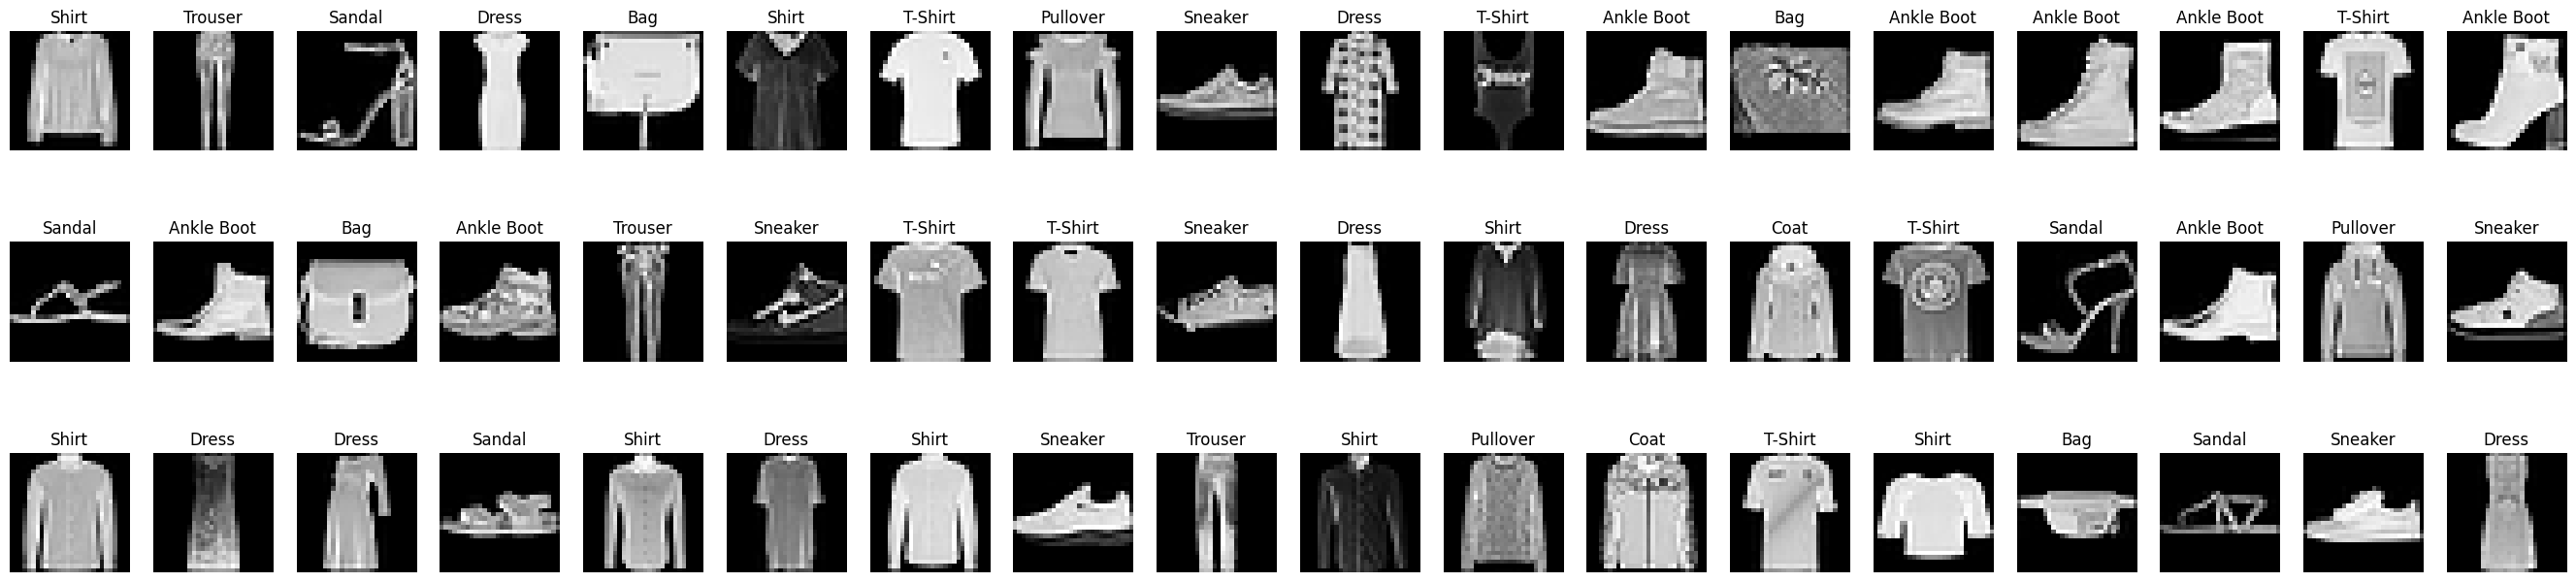

In [42]:
figure = plt.figure(figsize=(34, 8))
cols, rows = 18, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [43]:
# Crear DataLoaders
train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [44]:
train_loader

# **Model dummie**

In [45]:
class DenseNN(nn.Module):
    def __init__(self):
        super(DenseNN, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

# Crear el modelo
model = DenseNN().to(device)

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## *Training*

In [47]:
# Entrenamiento
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        # Mover los datos a la GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/30], Loss: 0.4369
Epoch [2/30], Loss: 0.3286
Epoch [3/30], Loss: 0.2980
Epoch [4/30], Loss: 0.3826
Epoch [5/30], Loss: 0.2774
Epoch [6/30], Loss: 0.1482
Epoch [7/30], Loss: 0.2906
Epoch [8/30], Loss: 0.2876
Epoch [9/30], Loss: 0.2818
Epoch [10/30], Loss: 0.3908
Epoch [11/30], Loss: 0.2873
Epoch [12/30], Loss: 0.3453
Epoch [13/30], Loss: 0.3150
Epoch [14/30], Loss: 0.3135
Epoch [15/30], Loss: 0.1634
Epoch [16/30], Loss: 0.1985
Epoch [17/30], Loss: 0.1156
Epoch [18/30], Loss: 0.1999
Epoch [19/30], Loss: 0.2531
Epoch [20/30], Loss: 0.2153
Epoch [21/30], Loss: 0.2158
Epoch [22/30], Loss: 0.1861
Epoch [23/30], Loss: 0.0992
Epoch [24/30], Loss: 0.2315
Epoch [25/30], Loss: 0.1662
Epoch [26/30], Loss: 0.1720
Epoch [27/30], Loss: 0.0849
Epoch [28/30], Loss: 0.2224
Epoch [29/30], Loss: 0.1361
Epoch [30/30], Loss: 0.0779


## *Results*

In [48]:
# Evaluación
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Mover los datos a la GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Obtener las predicciones
        _, predicted = torch.max(outputs, 1)

        # Contar aciertos
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calcular la precisión
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 89.40%


In [49]:
print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 89.40%


# **Optiomization 1**

In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, dropout, neuronPct, neuronShrink):
        super(NeuralNetwork, self).__init__()

        layers = []
        neuronCount = int(neuronPct * 5000)
        layer = 0

        prev_count = input_dim
        while neuronCount > 25 and layer < 10:
            layers.append(nn.Linear(prev_count, neuronCount))
            layers.append(nn.PReLU())
            layers.append(nn.Dropout(dropout))
            prev_count = neuronCount
            neuronCount = int(neuronCount * neuronShrink)
            layer += 1

        # Capa de salida corregida
        layers.append(nn.Linear(prev_count, output_dim))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [51]:
# Dimensiones de entrada y salida
input_dim = 28 * 28  # Tamaño de las imágenes aplanadas
output_dim = 10      # Número de clases

# Crear una instancia del modelo
model = NeuralNetwork(input_dim, output_dim, dropout=0.2, neuronPct=0.1, neuronShrink=0.25).to(device)

In [52]:
# Listas globales para almacenar las métricas
train_losses_all = []
val_losses_all = []
accuracies_all = []

# Definir la función de evaluación
def evaluate_network(learning_rate=1e-3, dropout=0.2, neuronPct=0.1, neuronShrink=0.25):
    kf = KFold(n_splits=5, shuffle=True)
    mean_benchmark = []
    epochs_needed = []

    # Listas para almacenar las métricas durante el entrenamiento
    train_losses = []
    val_losses = []
    accuracies = []

    x_data = torch.stack([img[0].view(-1) for img in training_data]).to(device)
    y_data = training_data.targets.clone().detach().to(device)

    for train_idx, test_idx in kf.split(x_data):
        x_train, y_train = x_data[train_idx], y_data[train_idx]
        x_test, y_test = x_data[test_idx], y_data[test_idx]

        # Inicializar el modelo
        input_dim = 28 * 28  # Tamaño de imágenes aplanadas
        output_dim = 10      # Número de clases

        model = NeuralNetwork(input_dim, output_dim, dropout, neuronPct, neuronShrink).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
        test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

        best_loss = float('inf')
        patience_counter = 0

        # Entrenamiento
        for epoch in range(10):  # Usar un valor real de EPOCHS aquí
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                # Calcular precisión
                _, predicted = torch.max(outputs, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

                running_loss += loss.item()

            # Guardar las métricas de cada epoch
            train_losses.append(running_loss / len(train_loader))
            accuracies.append(100 * correct / total)

            # Validación
            model.eval()
            with torch.no_grad():
                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test).item()
                val_losses.append(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= 3:  # Usar valor real de PATIENCE aquí
                epochs_needed.append(epoch)
                break

        # Evaluación final
        with torch.no_grad():
            model.eval()
            pred = model(x_test).cpu().numpy()
            y_compare = y_test.cpu().numpy()
            score = metrics.log_loss(y_compare, pred)
            mean_benchmark.append(score)

    # Almacenamos las métricas globalmente
    train_losses_all.extend(train_losses)
    val_losses_all.extend(val_losses)
    accuracies_all.extend(accuracies)

    # Retornar solo el valor negativo de la métrica de evaluación para la optimización
    return -statistics.mean(mean_benchmark)



In [53]:
mean_benchmark = evaluate_network(learning_rate=1e-3, dropout=0.2, neuronPct=0.1, neuronShrink=0.25)

## Bayesian optimization

In [54]:
# Definir el espacio de búsqueda para los hiperparámetros
pbounds = {'dropout': (0.0, 0.499),
           'learning_rate': (0.0, 0.1),
           'neuronPct': (0.01, 1),
           'neuronShrink': (0.01, 1)}

# Inicializar el optimizador
optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 imprime solo cuando se observa un máximo
    random_state=1,
)

# Iniciar el tiempo
start_time = time.time()

# Maximizar la función objetivo
optimizer.maximize(init_points=10, n_iter=20)

# Calcular el tiempo total de ejecución
time_took = time.time() - start_time
print(f"Total runtime: {time_took:.2f} segundos")

|   iter    |  target   |  dropout  | learni... | neuronPct | neuron... |
-------------------------------------------------------------------------
| 1         | -14.33    | 0.2081    | 0.07203   | 0.01011   | 0.3093    |
| 2         | -14.34    | 0.07323   | 0.009234  | 0.1944    | 0.3521    |
| 3         | -14.33    | 0.198     | 0.05388   | 0.425     | 0.6884    |
| 4         | -14.35    | 0.102     | 0.08781   | 0.03711   | 0.6738    |
| 5         | -14.35    | 0.2082    | 0.05587   | 0.149     | 0.2061    |
| 6         | -14.49    | 0.3996    | 0.09683   | 0.3203    | 0.6954    |
| 7         | -14.38    | 0.4373    | 0.08946   | 0.09419   | 0.04866   |
| 8         | -14.38    | 0.08475   | 0.08781   | 0.1074    | 0.4269    |
| 9         | -14.33    | 0.478     | 0.05332   | 0.695     | 0.3224    |
| 10        | -14.3     | 0.3426    | 0.08346   | 0.02811   | 0.7526    |
| 11        | -14.53    | 0.003852  | 0.01619   | 0.7123    | 0.7671    |
| 12        | -14.34    | 0.2208    | 

In [55]:
print(optimizer.max)

{'target': -12.65538787480491, 'params': {'dropout': 0.40820293255682355, 'learning_rate': 0.016352671207695214, 'neuronPct': 0.02488288532396405, 'neuronShrink': 0.16937882150810435}}


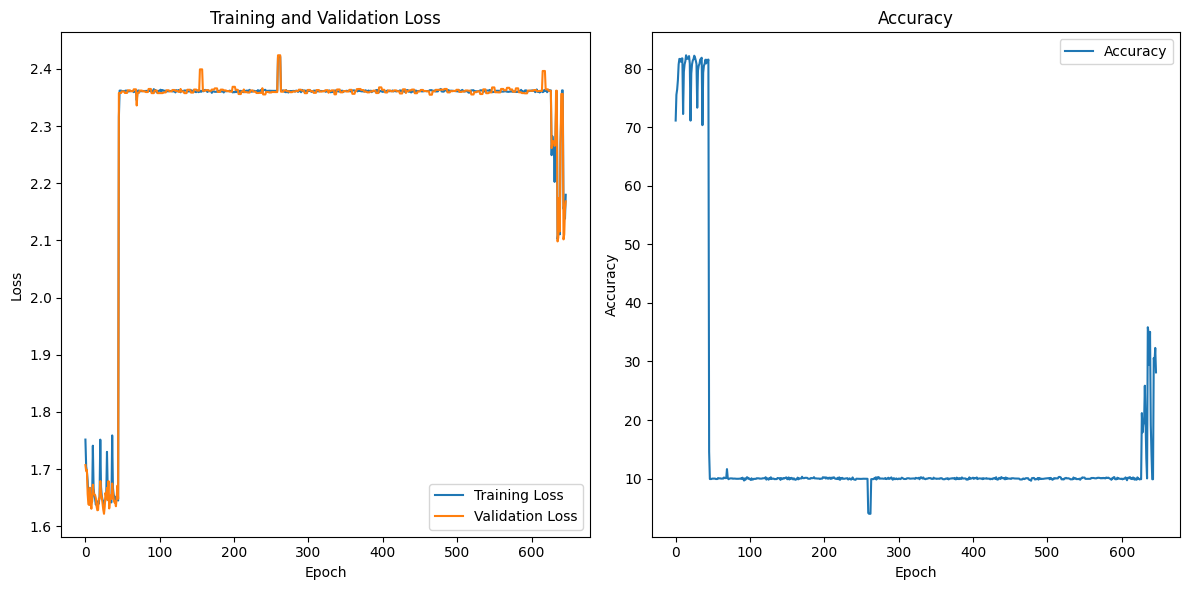

In [56]:
plt.figure(figsize=(12, 6))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(train_losses_all, label='Training Loss')
plt.plot(val_losses_all, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(accuracies_all, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
